# imports

In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from data_viz_functions import *

random_seed = 42

# reading data

In [2]:
DATA_DIR = 'kaggle/input'

df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# preprocessing

In [3]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [4]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [5]:
# Заподнение пропускоы в ['education'] наиболее частым значением 'SCH'
data["education"].fillna(data.education.mode(), inplace=True)

In [6]:
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

In [7]:
le = LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

In [8]:
data['age'] = np.log(data['age'] + 1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)

In [9]:
# Нормализация численных данных
for column in num_cols:
    data[column] = StandardScaler().fit_transform(np.array(data[column].values).reshape(-1, 1))

In [10]:
data.sample(5, random_state=random_seed).T

,74834,17526,75682,26882,28861
sex,0.000000,1.000000,0.000000,0.000000,1.000000
age,-1.130811,-0.773745,1.362924,-0.347997,-1.007707
car,0.000000,1.000000,0.000000,1.000000,0.000000
car_type,0.000000,1.000000,0.000000,0.000000,0.000000
decline_app_cnt,-0.418815,-0.418815,-0.418815,-0.418815,-0.418815
good_work,0.000000,0.000000,0.000000,0.000000,0.000000
score_bki,0.368124,-0.250086,-1.383239,0.317360,-0.992421
bki_request_cnt,1.109345,-1.334144,-1.334144,-0.281790,-0.281790
region_rating,6.000000,4.000000,3.000000,3.000000,3.000000
home_address,1.000000,1.000000,0.000000,0.000000,1.000000


# undersampling

In [11]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [12]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [13]:
# undersampling

rus = RandomUnderSampler(random_state=random_seed)
X_us, y_us = rus.fit_resample(X, y)


X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(
    X_us, y_us, test_size=0.10, shuffle=True, random_state=random_seed
)

# simple model

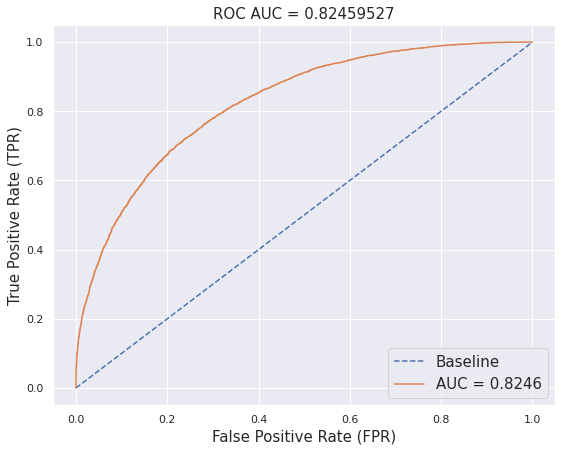

In [14]:
plot_roc_auc(
    y_train_us,
    CatBoostClassifier(silent=True)
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

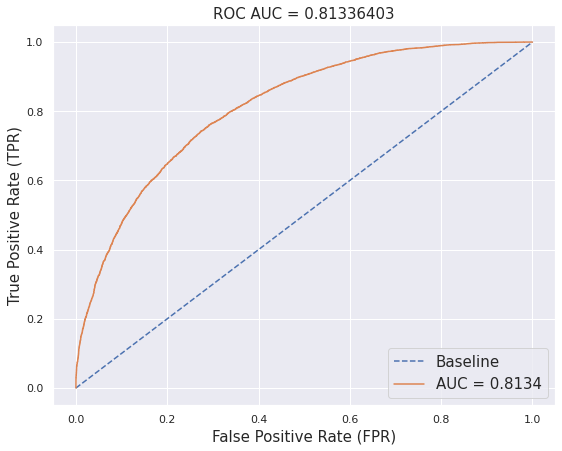

In [15]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

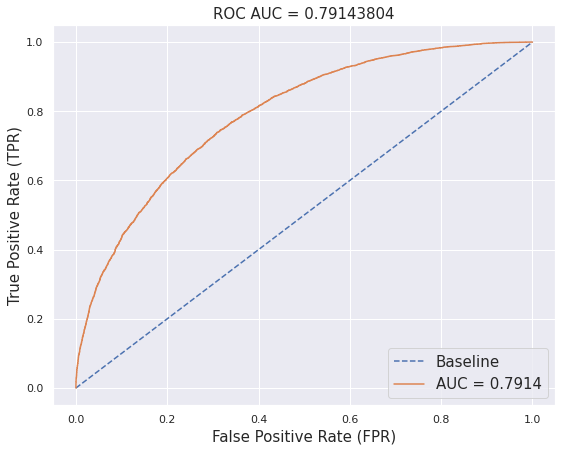

In [16]:
plot_roc_auc(
    y_train_us,
    HistGradientBoostingClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

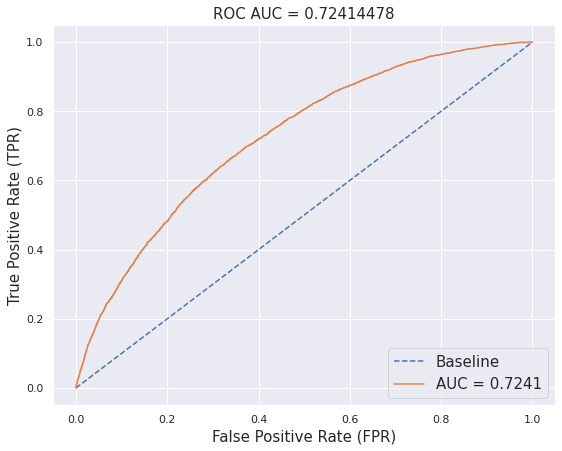

In [17]:
plot_roc_auc(
    y_train_us,
    LogisticRegression(solver="saga", max_iter=1000, random_state=random_seed) # уже хорошо отгридсёрченная в бейзлайне
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)


# parameter tuning

In [18]:
# import optuna
# import lightgbm as lgb


# def objective(trial):

#     from sklearn.metrics import roc_auc_score

#     train_x, test_x, train_y, test_y = train_test_split(
#         X_us, y_us, test_size=0.25, random_state=random_seed
#     )
#     dtrain = lgb.Dataset(train_x, label=train_y)

#     param = {
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
#         "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     }

#     gbm = lgb.train(param, dtrain)
#     preds = gbm.predict(test_x)
#     pred_labels = np.rint(preds)

#     score = roc_auc_score(test_y, pred_labels)
#     return score


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, timeout=600)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)


In [19]:
# study.best_params

[LightGBM] [Warning] bagging_fraction is set=0.4253162307244565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4253162307244565
[LightGBM] [Warning] lambda_l1 is set=2.3120410555682672e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3120410555682672e-06
[LightGBM] [Warning] feature_fraction is set=0.6580505530701052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6580505530701052
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.2760268497729425e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2760268497729425e-07


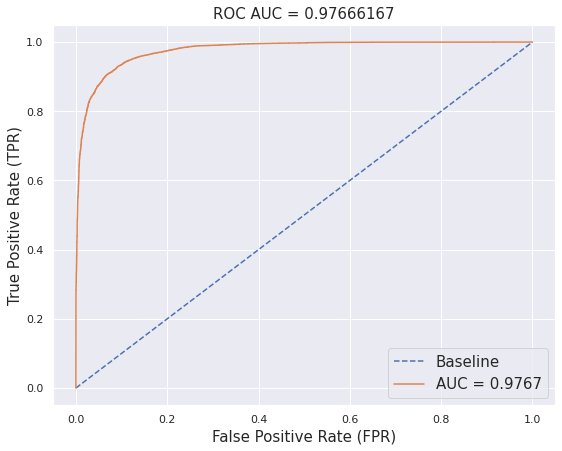

In [20]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier(
        **{
            "lambda_l1": 2.3120410555682672e-06,
            "lambda_l2": 1.2760268497729425e-07,
            "num_leaves": 256,
            "feature_fraction": 0.6580505530701052,
            "bagging_fraction": 0.4253162307244565,
            "bagging_freq": 4,
            "min_child_samples": 9,
        }
    )
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)


# final model

In [21]:
# model = CatBoostClassifier() # kaggle 0.33794
# model = LGBMClassifier() # kaggle 0.33657
model = LogisticRegression(solver='saga', max_iter=1000, random_state=random_seed) # kaggle 0.33933
# model = LGBMClassifier(
#     **{
#         "lambda_l1": 2.3120410555682672e-06,
#         "lambda_l2": 1.2760268497729425e-07,
#         "num_leaves": 256,
#         "feature_fraction": 0.6580505530701052,
#         "bagging_fraction": 0.4253162307244565,
#         "bagging_freq": 4,
#         "min_child_samples": 9,
#     }
# ) # kaggle 0.31080

# model.fit(X_us, y_us)
model.fit(X_train_us, y_train_us)
predict_submission = model.predict(test_data)

[LightGBM] [Warning] bagging_fraction is set=0.4253162307244565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4253162307244565
[LightGBM] [Warning] lambda_l1 is set=2.3120410555682672e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3120410555682672e-06
[LightGBM] [Warning] feature_fraction is set=0.6580505530701052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6580505530701052
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.2760268497729425e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2760268497729425e-07


# submision

In [22]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)

In [23]:
# !kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"

# Kaggle score: $0.33933$